In [1205]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


#print(os.getcwd())

input = pd.read_csv("Aerofoil.csv")#, index_col=0)
print(input.head(5))


   Alpha_deg  Lift_CL  Drag_CD  Normal_CN  Axial_CA
0          0   0.0000   0.0000     0.0000    0.0000
1         10   0.8628   0.0209     0.8533   -0.1293
2         15   1.0314   0.0577     1.0112   -0.2112
3         17   0.5802   0.2164     0.6181    0.0373
4         23   0.5752   0.3378     0.6615    0.0862


In [1206]:
input["Alpha_rad"] = np.radians(input['Alpha_deg'])
input.set_index('Alpha_rad', inplace=True)
print(input.head(5))

           Alpha_deg  Lift_CL  Drag_CD  Normal_CN  Axial_CA
Alpha_rad                                                  
0.000000           0   0.0000   0.0000     0.0000    0.0000
0.174533          10   0.8628   0.0209     0.8533   -0.1293
0.261799          15   1.0314   0.0577     1.0112   -0.2112
0.296706          17   0.5802   0.2164     0.6181    0.0373
0.401426          23   0.5752   0.3378     0.6615    0.0862


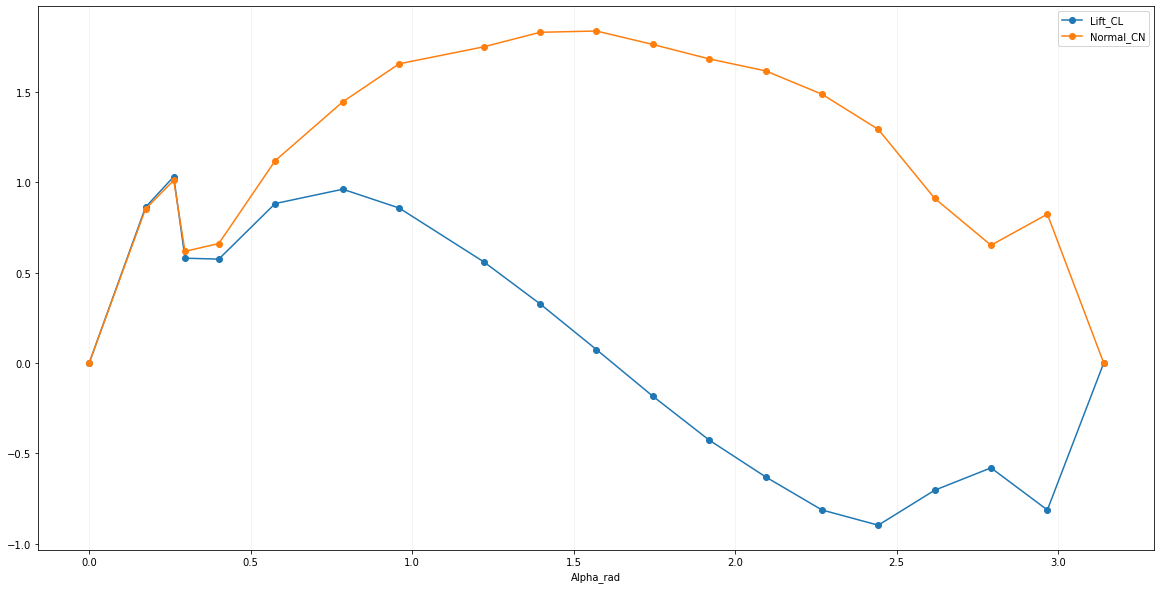

In [1207]:
input[['Lift_CL', 'Normal_CN']].plot(figsize=(20, 10), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

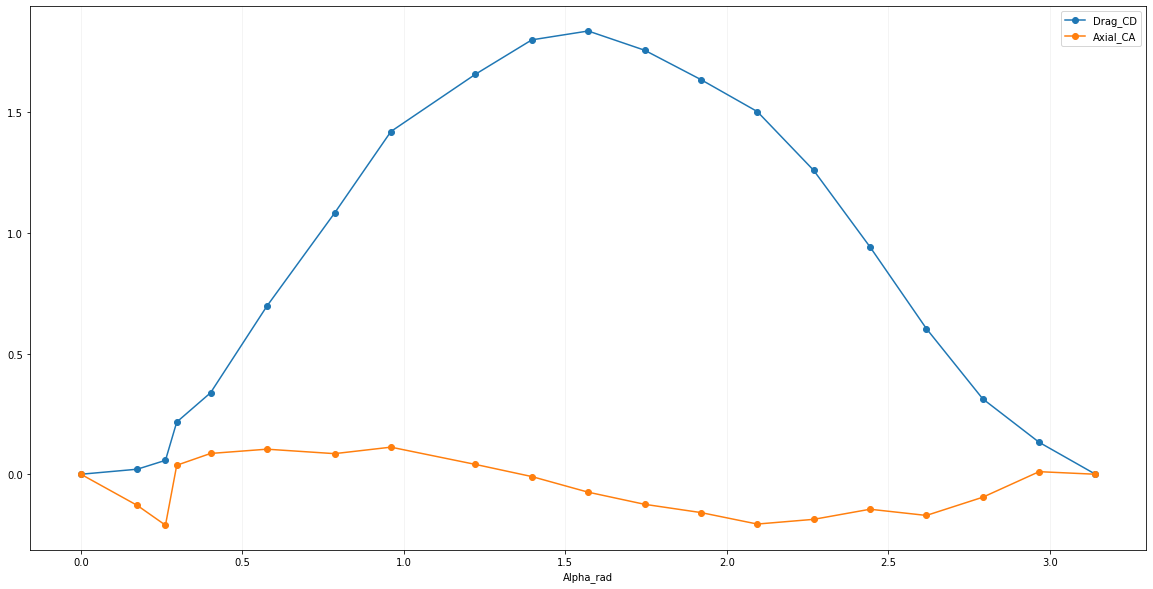

In [1208]:
input[['Drag_CD', 'Axial_CA']].plot(figsize=(20, 10), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

In [1209]:
def Step4_2(V, r, omega, a1, a2):
    x = V*(1+a1)
    y = r*omega*(1-a2)
    phi = math.atan((x/y))
    return phi

In [1210]:
def Step4_3(V, r, omega, a1, a2):
    x = (V*(1+a1))**2
    y = (r*omega*(1-a2))**2
    W = math.sqrt((x+y))
    return W

In [1211]:
def Step4_4(tetha, phi):
    alpha = tetha-phi
    return alpha

In [1212]:
def Step4_5(alpha):
    # CD = y = 0.2811x4 - 1.7609x3 + 2.6815x2 + 0.2642x - 0.0664
    # CL = y = 0.5492x3 - 2.6049x2 + 2.667x + 0.1758
    # CD = 0.2811*(alpha**4) - 1.7609*(alpha**3) + 2.6815*(alpha**2) + 0.2642*alpha - 0.0664
    # CL = 0.5492*(alpha**3) - 2.6049*(alpha**2) + 2.667*alpha + 0.1758
    CD = 0.2084*(alpha**6) - 0.0304*(alpha**5) - 1.201*(alpha**4) + 0.1098*(alpha**3) + 2.4518*(alpha**2) - 0.0769*alpha - 0.0036
    CL = 0.3926*(alpha**5) + 0.0619*(alpha**4) - 1.8013*(alpha**3) - 0.0942*(alpha**2) + 2.1784*alpha + 0.0716
    return CD, CL


In [1213]:
def Step4_6(density, W, N, c, r, CL, CD, phi):
    dT_dr = 0.5*density*(W**2)*N*c*((CL*math.cos(phi) - CD*math.sin(phi)))
    dQ_dr = 0.5*density*(W**2)*N*c*r*((CL*math.sin(phi) + CD*math.cos(phi)))
    return dT_dr, dQ_dr

In [1214]:
def Step4_7(dT_dr, density, r, V):
    constant = dT_dr/(4*math.pi*density*r*(V**2))
    # a1^2 + a2 -constant = 0
    a1_1 = (-1 + (math.sqrt(1+abs((4*constant))))) / 2
    a1_2 = (-1 - (math.sqrt(1+abs((4*constant))))) / 2

    return a1_1, a1_2

In [1215]:
def Step4_8(dQ_dr, density, r, V, omega, a1):
    a2 = dQ_dr/(4*math.pi*density*(r**3)*V*omega*(1+a1))
    return a2

In [1216]:
def Solidity(N, c, r):
    delta = (N*c)/(math.pi*r)
    return delta

# Main Code

In [1217]:
# Constants
_V = 74.597 # velocity m/s
_r = np.arange(start=0.1, stop=1.1, step=0.1) # radius m
_Omega = 50 # revs per second
_Omega = math.radians(_Omega) # radians per second

Tetha = np.arange(start=2,stop=5, step=0.3) # to be converted into radians
_Tetha = []
for n in reversed(Tetha):
    _Tetha.append(n)
_N = 3 # number of blades
_chordLength = 0.1 # chord length in m
_Density = 0.7 # kg/m**3
_crosssections = _r.size # number of cross sections

# print("Solidity :", Solidity(_N, _c, _r))
results = []

In [1218]:
for c in range(_crosssections): # cross section loop
    # Variables
    _a1_new = 0
    _a2_new = 0
    _a1_prev = 0
    _a2_prev = 0

    _tetha = math.radians(_Tetha[c])# twist angle loop
    _radius = _r[c]

    for i in range(0,20): # convergence loop, i.e. when a1 & a2 stabilize

        phi = Step4_2(_V, _radius, _Omega, _a1_prev, _a2_prev)
        #print("Phi :", phi)

        W = Step4_3(_V, _radius, _Omega, _a1_prev, _a2_prev)
        #print("W :", W)

        alpha = Step4_4(_tetha, phi)
        #print("aplha :", alpha)

        CD, CL = Step4_5(alpha)
        #print("CL :", CL)
        #print("CD :", CD)

        dT_dr, dQ_dr = Step4_6(_Density, W, _N, _chordLength, _radius, CL, CD, phi)
        #print("dT_dr :", dT_dr)
        #print("dQ_dr :", dQ_dr)

        # constant = dT_dr/(4*math.pi*_Density*_r*(_V**2))

        _a1_new, bad_a1 = Step4_7(dT_dr, _Density, _radius, _V)
        #print("_a1_new :", _a1_new)
        #print("bad_a1 :", bad_a1)

        _a2_new = Step4_8(dQ_dr, _Density, _radius, _V, _Omega, _a1_new)
        #print("_a2_new :", _a2_new)
        results.append([_radius, _Tetha[c], _tetha, _a1_new, _a2_new, W, alpha, CD, CL])

        _a1_prev = (_a1_new + _a1_prev)/2
        _a2_prev = (_a2_new + _a2_prev)/2 # avg prev and new calc

In [1219]:
output = pd.DataFrame(columns=['radius', 'ThetaInDeg', 'ThetaInRad', 'a1', 'a2', 'W', 'alpha', 'CD', 'CL'], data=results)
#output.to_csv("Iterations.csv")

In [1220]:
# Find converging numbers by finding the maximum from each section
output.set_index('radius', inplace=True)
# print(output.groupby(level=0).apply(max))
outputMax = output.groupby(level=0).apply(max)

In [1221]:
def StepTr(a1, density, r, V):
    dT_dr = 4*math.pi*density*r*(V**2)*a1*(1+a1)
    return dT_dr

In [1222]:
def StepdQ(a1, a2, density, r, V, omega):
    dQ_dr = (4*math.pi*density*(r**3)*V*omega*a2*(1+a1))
    return dQ_dr

In [1223]:
# Range of V
# _V = [40, 68, 63, 78, 64, 69, 88, 40, 43, 44]
_V = [10, 40, 50, 60, 70, 85, 73, 69, 55, 45]
import random 
# outputMax['RangeOfV'] = random.sample(range(60, 100), outputMax.shape[0])
outputMax['RangeOfV'] = _V
TrustAndTorque = outputMax.assign(Tr = lambda x: StepTr(x['a1'], _Density, _radius, x['RangeOfV']))
TrustAndTorque = TrustAndTorque.assign(dQ = lambda x: StepdQ(x['a1'], x['a2'],_Density, _radius, x['RangeOfV'], _Omega))


# TrustAndTorque = outputMax.assign(Tr = lambda x: StepTr(x['a1'], _Density, _radius, _V))
# TrustAndTorque = TrustAndTorque.assign(dQ = lambda x: StepdQ(x['a1'], x['a2'],_Density, _radius, _V, _Omega))
print(TrustAndTorque)

        ThetaInDeg  ThetaInRad        a1        a2          W     alpha  \
radius                                                                    
0.1            4.7    0.082030  0.268490 -0.214510  94.618496 -1.487553   
0.2            4.4    0.076794  0.118606  0.056512  83.444435 -1.491662   
0.3            4.1    0.071558  0.076202  0.079755  80.281711 -1.495728   
0.4            3.8    0.066323  0.056184  0.074309  78.788782 -1.499794   
0.5            3.5    0.061087  0.044528  0.065744  77.919725 -1.503861   
0.6            3.2    0.055851  0.036901  0.057856  77.351293 -1.507927   
0.7            2.9    0.050615  0.031523  0.051161  76.950691 -1.511993   
0.8            2.6    0.045379  0.027527  0.045559  76.653322 -1.516059   
0.9            2.3    0.040143  0.024442  0.040856  76.423988 -1.520126   
1.0            2.0    0.034907  0.021988  0.036875  76.241872 -1.524192   

              CD        CL  RangeOfV           Tr         dQ  
radius                              

### TrapzzyRule

In [1224]:
h = (_r[-1] - _r[0]) / (_r.size -1) # last value - first value / num of elements -1
print(h)

0.1


In [1225]:

y = TrustAndTorque['Tr'].to_numpy()
y_bracket = np.sum(y[1:-1])*2
square_bracket = y[0] + y[-1] + y_bracket
Tr_integ = 0.5*h*square_bracket


In [1226]:
y = TrustAndTorque['dQ'].to_numpy()
y_bracket = np.sum(y[1:-1])*2
square_bracket = y[0] + y[-1] + y_bracket
dQ_integ = 0.5*h*square_bracket

In [1227]:
print("Thrust: {0}".format(Tr_integ))
print("Torque: {0}".format(dQ_integ))

Thrust: 1371.1503429852255
Torque: 23.26509577518304


In [1228]:
# Add computed columns for trappy
TrustAndTorque['Tr_integ'] = None
TrustAndTorque['dQ_integ'] = None

In [1229]:
tt = TrustAndTorque['Tr'].to_numpy()
for index in range(len(tt)):
    if index < tt.size-1:
        square_bracket = tt[index] + tt[index+1]
        Tr_integ = 0.5*h*square_bracket
        # insert computed value
        TrustAndTorque.loc[TrustAndTorque.Tr == tt[index], 'Tr_integ'] = Tr_integ
        print(Tr_integ)

108.34380144798129
183.5379215452671
184.13137223069873
194.19566342888044
221.82741508161655
197.80284073553912
135.44146427060983
92.54201774347572
53.32784650115657


In [1230]:
tt = TrustAndTorque['dQ'].to_numpy()
for index in range(len(tt)):
    if index < tt.size-1:
        square_bracket = tt[index] + tt[index+1]
        dQ_integ = 0.5*h*square_bracket
        # insert computed value
        TrustAndTorque.loc[TrustAndTorque.dQ == tt[index], 'dQ_integ'] = dQ_integ
        print(dQ_integ)

-0.07385772835636288
2.617718222390867
3.4546019180114893
3.652425574803512
3.8022040793504632
3.435828828175805
2.7184048261532383
2.1233148287895336
1.534455225864493


In [1231]:
print(TrustAndTorque)

        ThetaInDeg  ThetaInRad        a1        a2          W     alpha  \
radius                                                                    
0.1            4.7    0.082030  0.268490 -0.214510  94.618496 -1.487553   
0.2            4.4    0.076794  0.118606  0.056512  83.444435 -1.491662   
0.3            4.1    0.071558  0.076202  0.079755  80.281711 -1.495728   
0.4            3.8    0.066323  0.056184  0.074309  78.788782 -1.499794   
0.5            3.5    0.061087  0.044528  0.065744  77.919725 -1.503861   
0.6            3.2    0.055851  0.036901  0.057856  77.351293 -1.507927   
0.7            2.9    0.050615  0.031523  0.051161  76.950691 -1.511993   
0.8            2.6    0.045379  0.027527  0.045559  76.653322 -1.516059   
0.9            2.3    0.040143  0.024442  0.040856  76.423988 -1.520126   
1.0            2.0    0.034907  0.021988  0.036875  76.241872 -1.524192   

              CD        CL  RangeOfV           Tr         dQ    Tr_integ  \
radius                 

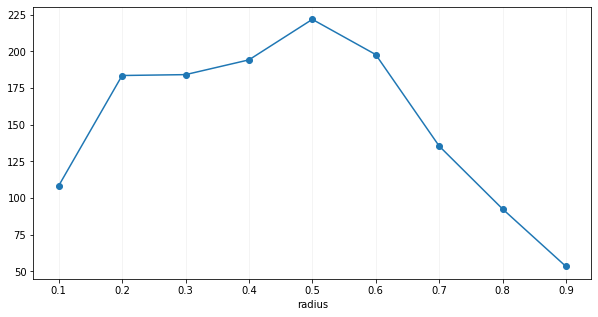

In [1232]:
TrustAndTorque['Tr_integ'].plot(figsize=(10, 5), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

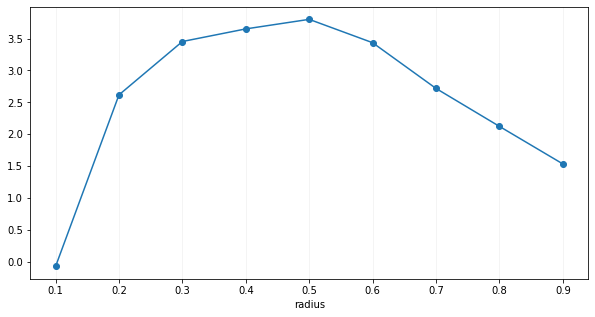

In [1233]:
TrustAndTorque['dQ_integ'].plot(figsize=(10, 5), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

### Advanced Ratio

In [1234]:
# Advance ratio
n = 50 # revs per second
D = _r[-1]*2 # diameter = radius * 2

_J = []
for v in TrustAndTorque['RangeOfV']:
    _J.append(v/(n*D))

_J.sort()

TrustAndTorque['AdvRatio'] = _J

print(_J)

[0.1, 0.4, 0.45, 0.5, 0.55, 0.6, 0.69, 0.7, 0.73, 0.85]


### Eff

In [1235]:
TrustAndTorque['efficiency'] = (TrustAndTorque['Tr_integ'] * TrustAndTorque['RangeOfV']) / (TrustAndTorque['dQ_integ']  * 50)

In [1236]:
print(TrustAndTorque[['RangeOfV','efficiency']])

        RangeOfV  efficiency
radius                      
0.1           10 -293.385144
0.2           40   56.090963
0.3           50   53.300316
0.4           60    63.80275
0.5           70   81.678515
0.6           85   97.870076
0.7           73   72.742859
0.8           69   60.145572
0.9           55   38.228962
1.0           45         NaN


In [1237]:
print(TrustAndTorque.loc[0.2:0.9])

        ThetaInDeg  ThetaInRad        a1        a2          W     alpha  \
radius                                                                    
0.2            4.4    0.076794  0.118606  0.056512  83.444435 -1.491662   
0.3            4.1    0.071558  0.076202  0.079755  80.281711 -1.495728   
0.4            3.8    0.066323  0.056184  0.074309  78.788782 -1.499794   
0.5            3.5    0.061087  0.044528  0.065744  77.919725 -1.503861   
0.6            3.2    0.055851  0.036901  0.057856  77.351293 -1.507927   
0.7            2.9    0.050615  0.031523  0.051161  76.950691 -1.511993   
0.8            2.6    0.045379  0.027527  0.045559  76.653322 -1.516059   
0.9            2.3    0.040143  0.024442  0.040856  76.423988 -1.520126   

              CD        CL  RangeOfV           Tr         dQ    Tr_integ  \
radius                                                                     
0.2     1.776562 -0.001525        40  1867.289226  19.410468  183.537922   
0.3     1.779561  0.0

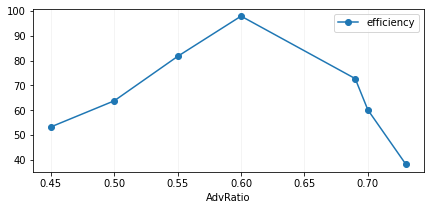

In [1238]:
Chart_1 = TrustAndTorque.loc[0.3:0.9, ['AdvRatio', 'efficiency']].set_index('AdvRatio')

Chart_1.plot(figsize=(7, 3), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

### CT

In [1239]:
TrustAndTorque['Ct'] = TrustAndTorque['Tr_integ']/(_Density * n**2  * D**4 )
print(TrustAndTorque['Ct'])

radius
0.1    0.003869
0.2    0.006555
0.3    0.006576
0.4    0.006936
0.5    0.007922
0.6    0.007064
0.7    0.004837
0.8    0.003305
0.9    0.001905
1.0         NaN
Name: Ct, dtype: object


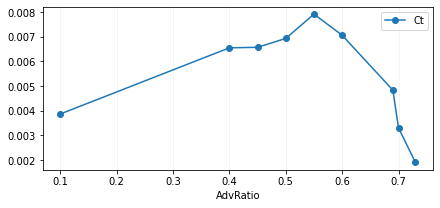

In [1240]:
Chart_2 = TrustAndTorque[['AdvRatio', 'Ct']].set_index('AdvRatio')

Chart_2.plot(figsize=(7, 3), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

### Cp

In [1241]:
P = [122000, 124000, 126000, 123000, 120000, 117000, 110000, 100000, 98000, 95000]

TrustAndTorque['Cp'] = P/(_Density * n**3  * D**5 )
print(TrustAndTorque['Ct'])

radius
0.1    0.003869
0.2    0.006555
0.3    0.006576
0.4    0.006936
0.5    0.007922
0.6    0.007064
0.7    0.004837
0.8    0.003305
0.9    0.001905
1.0         NaN
Name: Ct, dtype: object


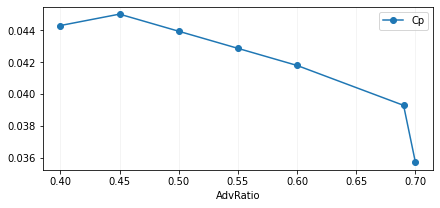

In [1242]:
Chart_3 = TrustAndTorque.loc[0.2:0.8,['AdvRatio', 'Cp']].set_index('AdvRatio')

Chart_3.plot(figsize=(7, 3), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

### Cq

In [1243]:
TrustAndTorque['Cq'] = TrustAndTorque['dQ_integ']/(_Density * n**2  * D**5 )
print(TrustAndTorque['Cq'])

radius
0.1   -0.000001
0.2    0.000047
0.3    0.000062
0.4    0.000065
0.5    0.000068
0.6    0.000061
0.7    0.000049
0.8    0.000038
0.9    0.000027
1.0         NaN
Name: Cq, dtype: object


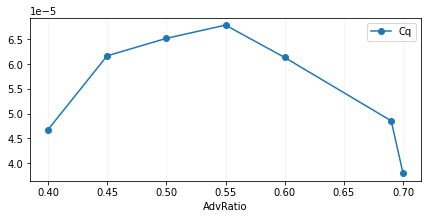

In [1244]:
Chart_4 = TrustAndTorque.loc[0.2:0.8,['AdvRatio', 'Cq']].set_index('AdvRatio')

Chart_4.plot(figsize=(7, 3), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

### Elemental Efficiency

In [1253]:
sub_TrustAndTorque = TrustAndTorque[['RangeOfV', 'a1', 'a2', 'W', 'alpha', 'CD', 'CL']]
sub_TrustAndTorque.reset_index(inplace=True)
ElementEff = ((((sub_TrustAndTorque['RangeOfV'])/(sub_TrustAndTorque['radius']*_Omega))**2) * (sub_TrustAndTorque['a1']/sub_TrustAndTorque['a2']))
TrustAndTorque['ElementEff'] = ElementEff.values # output of above returns Series

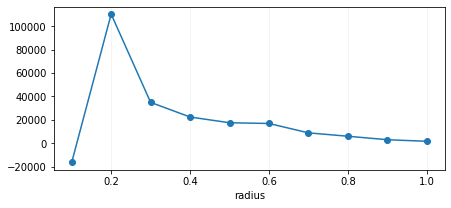

In [1259]:
Chart_5 = TrustAndTorque.ElementEff

Chart_5.plot(figsize=(7, 3), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

### Drag

In [1262]:
Drag = (0.5*_chordLength*sub_TrustAndTorque['radius']*sub_TrustAndTorque['CD']*_Density*(sub_TrustAndTorque['W']**2))
TrustAndTorque['Drag'] = Drag.values # output of above returns Series

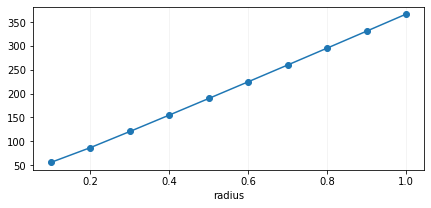

In [1263]:
Chart_6 = TrustAndTorque.Drag

Chart_6.plot(figsize=(7, 3), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

# Lift

In [1264]:
Lift = (0.5*_chordLength*sub_TrustAndTorque['radius']*sub_TrustAndTorque['CL']*_Density*(sub_TrustAndTorque['W']**2))
TrustAndTorque['Lift'] = Lift.values # output of above returns Series

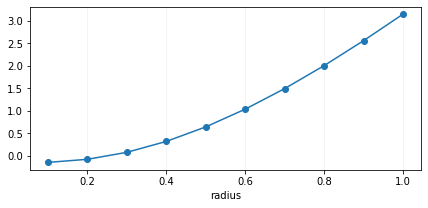

In [1265]:
Chart_7 = TrustAndTorque.Lift

Chart_7.plot(figsize=(7, 3), marker="o")

plt.grid(axis='x', color='0.95')
plt.show()

In [1266]:
TrustAndTorque.to_csv("TrustAndTorque.csv")